In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2
from keras import backend as K
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error as msle
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

rs = 0

In [46]:
data = pd.read_csv('carsaledataset.csv')
data = data.drop(['min_cost_price', 'max_cost_price'] , axis=1)
data.head()

,brand,model,vehicle_age,km_driven,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price,sale_state
0,Maruti,Alto,9,120000,Petrol,0,19.70,796,46.30,5,120000,Gujarat
1,Hyundai,Grand,5,20000,Petrol,0,18.90,1197,82.00,5,550000,Maharashtra
2,Hyundai,i20,11,60000,Petrol,0,17.00,1197,80.00,5,215000,Madhya Pradesh
3,Maruti,Alto,9,37000,Petrol,0,20.92,998,67.10,5,226000,Rajasthan
4,Ford,Ecosport,6,30000,Diesel,0,22.77,1498,98.59,5,570000,West Bengal


In [47]:
train, test = train_test_split(data, test_size=1/20, random_state=rs)
train, valid = train_test_split(train, test_size=1/19, random_state=rs)

print('Train shape:', train.shape)
print('Validation shape:', valid.shape)
print('Test shape:', test.shape)
train.selling_price.describe()

Train shape: (13869, 12)
Validation shape: (771, 12)
Test shape: (771, 12)


count    1.386900e+04
mean     7.753544e+05
std      9.005910e+05
min      4.000000e+04
25%      3.800000e+05
50%      5.550000e+05
75%      8.250000e+05
max      3.950000e+07
Name: selling_price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

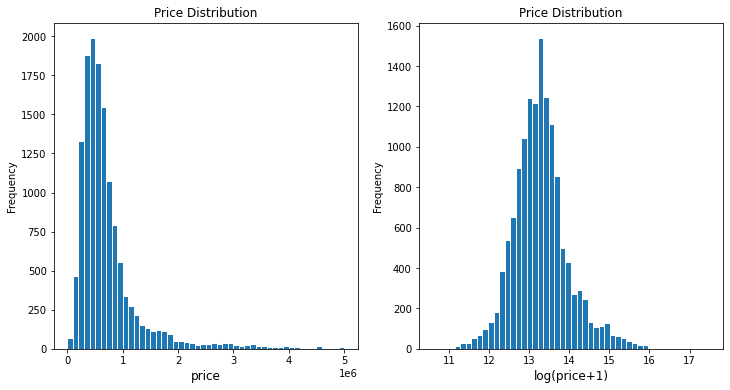

In [48]:
plt.subplot(1, 2, 1)
(train['selling_price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 5000000])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.subplot(1, 2, 2)
np.log(train['selling_price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

We look at what percentage of cars sold were automatic vs manual, then compare the price data for both.

In [49]:
train['transmission_type'].value_counts() / len(train)

0    0.793424
1    0.206576
Name: transmission_type, dtype: float64

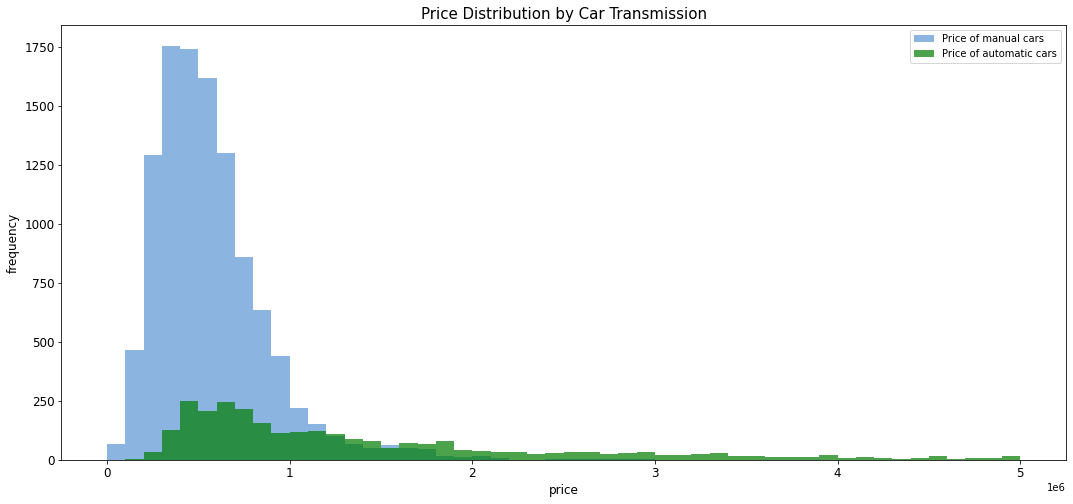

In [50]:
manualts = train.loc[train['transmission_type'] == 0, 'selling_price']
automaticts = train.loc[train['transmission_type'] == 1, 'selling_price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(manualts, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 5000000],
       label='Price of manual cars')
ax.hist(automaticts, color='#007D00', alpha=0.7, bins=50, range = [0, 5000000],
       label='Price of automatic cars')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Car Transmission', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

bingo, the prices are more diverse in terms of automatic cars. let's find their mean

In [51]:
print('The average price is {}'.format(round(automaticts.mean(), 2)), 'if car is automatic')
print('The average price is {}'.format(round(manualts.mean(), 2)), 'if car is manual')

The average price is 1584531.94 if car is automatic
The average price is 564677.02 if car is manual


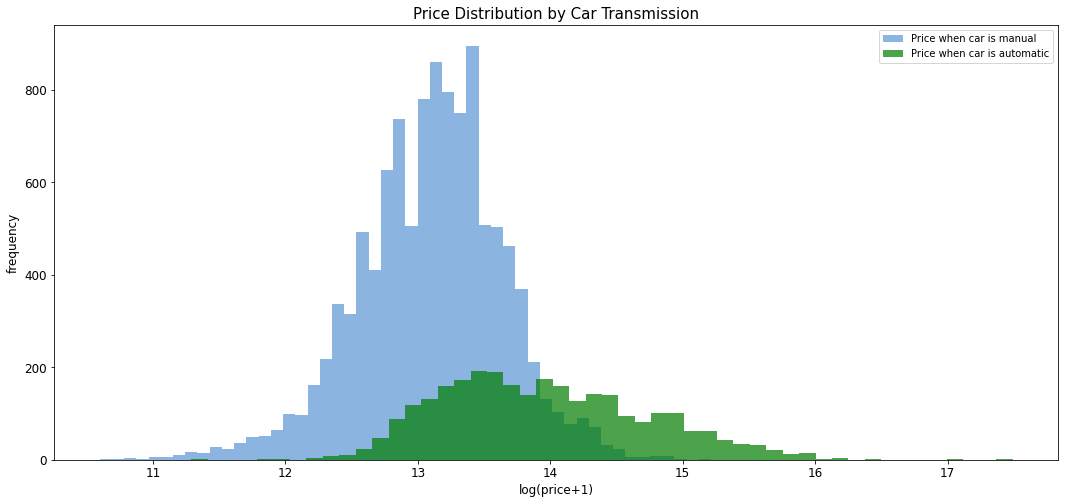

In [52]:
# plot the log curve again

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(manualts+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when car is manual')
ax.hist(np.log(automaticts+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when car is automatic')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Car Transmission', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [53]:
test_new = train.drop(['selling_price'] , axis=1)
nrow_train = train.shape[0]
y = np.log1p(train["selling_price"])
merge: pd.DataFrame = pd.concat([train, test_new])

In [54]:
# convert all data to matrices the AI can understand
transformer = make_column_transformer(
    (MinMaxScaler(), 
        ['engine', 'mileage', 'seats', 
         'vehicle_age', 'km_driven', 'max_power']),
    (OneHotEncoder(handle_unknown='ignore'), 
        ['brand', 'model', 'fuel_type', 'sale_state'])
)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    test_new, y, test_size=0.05, random_state=42
)

In [56]:
# Fit
transformer.fit(X_train)

# Apply the transformation
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

tensorflow doesn't understand that so we turn it back to a numpy array.

In [57]:
X_train.toarray()

array([[0.07800192, 0.55179418, 0.55555556, ..., 0.        , 0.        ,
        0.        ],
       [0.13525456, 0.46716317, 0.55555556, ..., 0.        , 0.        ,
        0.        ],
       [0.25936599, 0.34563304, 0.55555556, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08741595, 0.7647258 , 0.55555556, ..., 0.        , 0.        ,
        1.        ],
       [0.03938521, 1.        , 0.55555556, ..., 0.        , 0.        ,
        1.        ],
       [0.2309318 , 0.56465809, 0.55555556, ..., 0.        , 0.        ,
        0.        ]])

make an rmse function to see progress

In [58]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [72]:
tf.random.set_seed(0)

model = Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(
    loss=rmse,
    optimizer='Adam',
    metrics=[rmse]
)

model.fit(X_train.toarray(), y_train, epochs=175)

Epoch 1/175
412/412 [==============================] - 1s 1ms/step - loss: 0.8681 - rmse: 0.8677
Epoch 2/175
412/412 [==============================] - 0s 1ms/step - loss: 0.3014 - rmse: 0.3014
Epoch 3/175
412/412 [==============================] - 0s 1ms/step - loss: 0.2722 - rmse: 0.2722
Epoch 4/175
412/412 [==============================] - 0s 1ms/step - loss: 0.2602 - rmse: 0.2602
Epoch 5/175
412/412 [==============================] - 1s 1ms/step - loss: 0.2573 - rmse: 0.2573
Epoch 6/175
412/412 [==============================] - 0s 1ms/step - loss: 0.2424 - rmse: 0.2425
Epoch 7/175
412/412 [==============================] - 0s 1ms/step - loss: 0.2404 - rmse: 0.2404
Epoch 8/175
412/412 [==============================] - 0s 1ms/step - loss: 0.2314 - rmse: 0.2314
Epoch 9/175
412/412 [==============================] - 0s 1ms/step - loss: 0.2287 - rmse: 0.2287
Epoch 10/175
412/412 [==============================] - 1s 1ms/step - loss: 0.2331 - rmse: 0.2331
Epoch 11/175
412/412 [=======

In [73]:
model.save('./tensorflow')

INFO:tensorflow:Assets written to: ./tensorflow\assets


In [76]:
predictions = model.predict(X_test)
predictions[:5]

array([[12.447054 ],
       [13.504819 ],
       [13.6219225],
       [13.496329 ],
       [12.693726 ]], dtype=float32)